# COMPAS Results for Bayesian Neural network + RATE - ICML

Find recidivism risk score data and previous analysis on [ProPublica](https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis).

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp # Needs separate install on top of standard Tensorflow 
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from scipy.stats import spearmanr, rankdata
import pandas as pd
#from ggplot import *
import random
import copy
import warnings
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from random import *

# To import scripts from different directory
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, "/".join([parent_dir, "src"])) 

from utils import *
from BayesNN import BNN
from rate_bnn import *

/home/jonathan/miniconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .linbin import fast_linbin
/home/jonathan/miniconda2/lib/python2.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:11: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._smoothers_lowess import lowess as _lowess


It is advised you run this notebook twice: once with `variables_to_remove = []` and next with `variables_to_remove = ['priors_count']` (see below cell). Do not restart the kernel between runs. The result is a dataset `rate_data_csv` that may be written to file (uncomment last cell when ready to do so). The contents are first and second order RATE values when all variables are included, and first and second order RATE values when number of prior offenses is omitted.

In [3]:
# options for analysis

# if True, use raw risk class: Low, Medium, High.
# if False, analyze as ProPublica did, binning Medium/High into a single group (this is our primary interest)
multiclass = False

# At first pass, it is not advised you remove variables
variables_to_remove = []
# variables_to_remove = ['priors_count']

In [4]:
# Load COMPAS data
raw_data = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')

# Remove missingness as ProPublica did
complete_data = raw_data[(raw_data['days_b_screening_arrest'] <= 30) & 
         (raw_data['days_b_screening_arrest'] >= -30) & 
         (raw_data['is_recid'] != -1) & 
         (raw_data['c_charge_degree'] != 'O') & 
         (raw_data['score_text'] != 'N/A')]

# Organize factors same as ProPublica
complete_data.rename(index=str, columns={"c_charge_degree": "crime_factor"}, inplace=True)

complete_data['race_factor'] = complete_data['race'].astype('category')
complete_data['race_factor'].cat.reorder_categories(['Caucasian', 'African-American', 
                                             'Asian', 'Hispanic', 
                                             'Native American', 'Other'], inplace=True)

complete_data['gender_factor'] = complete_data['sex'].astype('category')
complete_data['gender_factor'].cat.reorder_categories(['Male', 'Female'], inplace=True)

complete_data['age_factor'] = complete_data['age_cat']

/home/jonathan/miniconda2/lib/python2.7/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/home/jonathan/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/jonathan/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

In [5]:
# Choose to bin Medium and High together, as ProPublica did (main ICML text)
# or leave Low, Medium, High as three classes

if multiclass: 
    # three responses
    complete_data['score_factor'] = complete_data['score_text'].astype('category')
    complete_data['score_factor'].cat.reorder_categories(['Low', 'Medium', 'High'], inplace=True)
    
    # One-hot encode features
    onehot_predictors = pd.get_dummies(complete_data, 
                             columns = ['crime_factor', 'age_factor', 
                                       'race_factor', 'gender_factor'], 
                            drop_first = True)
    
    # need three one-hot columns to persist for response
    onehot_response = pd.get_dummies(complete_data, columns = ['score_factor'])
    response_columns = ['score_factor_Low', 'score_factor_Medium', 'score_factor_High']
    
    onehot_data = pd.concat([onehot_predictors.reset_index(drop=True), 
                         onehot_response.ix[:, response_columns].reset_index(drop=True)], axis=1)
else: 
    # binary response: Low v. Medium/High
    complete_data['score_factor'] = np.where(complete_data['score_text'] == 'Low', 'LowScore', 'HighScore')
    complete_data['score_factor'] = complete_data['score_factor'].astype('category')
    complete_data['score_factor'].cat.reorder_categories(['LowScore', 'HighScore'], inplace=True)
    
    # One-hot encode features
    onehot_data = pd.get_dummies(complete_data, 
                             columns = ['crime_factor', 'age_factor', 
                                       'race_factor', 'gender_factor', 
                                       'score_factor'], 
                            drop_first = True)
    
    response_columns = ['score_factor_HighScore']

/home/jonathan/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jonathan/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
# Use the features ProPublica used, less two year recidivism
ProPublica_features = ['crime_factor_M', 
                        'priors_count', 
                        'age_factor_Greater than 45', 
                        'age_factor_Less than 25', 
                        'race_factor_African-American', 
                        'race_factor_Asian', 
                        'race_factor_Hispanic', 
                        'race_factor_Native American', 
                        'race_factor_Other', 
                        'gender_factor_Female']

# recall full feature list length (with one-hot) for plots
num_ProPublica_features = len(ProPublica_features)

# Add response vector
model_columns = ProPublica_features  # use ProPublica predictors
model_columns.extend(response_columns)  # add response column(s)

# define PANDAS modeling data
model_data = onehot_data.ix[:, model_columns]

/home/jonathan/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/jonathan/miniconda2/lib/python2.7/site-packages/pandas/core/indexing.py:890: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


In [7]:
# REMOVE VARIABLES

if len(variables_to_remove) > 0:
    model_data.drop(variables_to_remove, axis=1, inplace=True)

In [8]:
# SCRAMBLE VARIABLES
# Optional, not advised.
# Set shuffle = True, normalsmp = False to permute the priors_count column
# Set shuffle = True, normalsmp = True to replace the priors_count column with N(0, 1) random sample

shuffle = False
normalsmp = False

if shuffle:
    np.random.seed(randint(0, 99999))  # set new numpy random seed
    priors_count = copy.deepcopy(model_data['priors_count'])
    model_data.drop('priors_count', axis=1, inplace=True)

    if normalsmp:
        # sample from normal random variable
        model_data['priors_count_normalsmp'] = np.random.normal(0, 1, model_data.shape[0])
    else: 
        # permute the priors_count column
        model_data['priors_count_shuffled'] = np.random.permutation(priors_count)

In [9]:
# Normalize the priors count variable (shuffled or not)
# the only continuous predictor

# normalizing this variable makes the covariance projection == correlation projection
correlation = False

if correlation: 
    cols = ["priors_count", "priors_count_shuffled", "priors_count_normalsmp"]
    priors_col = [model_data.columns.get_loc(c) for c in model_data.columns if c in cols]
    if len(priors_col) > 0:
        model_data.ix[:, priors_col[0]] = preprocessing.scale(model_data.ix[:, priors_col[0]])

In [10]:
# Define training and test splits
# This is not necessary, as we are not interested in prediction.

train_test_splits = False

if train_test_splits: 
    x_train, x_test = train_test_split(model_data, test_size=0.2)
    y_train_mat = x_train.ix[:, response_columns].values
    x_train.drop(columns = response_columns, inplace=True)
    bnn_predictors = x_train.columns
    x_train_mat = x_train.values
    
    y_test_mat = x_test.ix[:, response_columns].values
    x_test.drop(columns = response_columns, inplace=True)
    x_test_mat = x_test.values
else: 
    x_train = model_data
    y_train_mat = x_train.ix[:, response_columns].values
    y_test_mat = y_train_mat
    x_train.drop(columns = response_columns, inplace=True)
    bnn_predictors = x_train.columns
    x_train_mat = x_train.values
    x_test_mat = x_train_mat
    
n_train = x_train_mat.shape[0]
n_test = x_test_mat.shape[0]

# Input and output dimensionality
p = x_train_mat.shape[1]
C = y_train_mat.shape[1]

# set up space to save rate values
if 'rate_data_csv' not in locals():
    rate_data_csv = pd.DataFrame({"var_names": ProPublica_features})
    if shuffle and not normalsmp:
        rate_data_csv["var_names"].replace("priors_count_shuffled", "priors_count", inplace=True)
    if shuffle and normalsmp:
        rate_data_csv["var_names"].replace("priors_count_normalsmp", "priors_count", inplace=True)

/home/jonathan/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/jonathan/miniconda2/lib/python2.7/site-packages/pandas/core/indexing.py:890: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


Now define the network architecture. The BNN class constructor (defined in BayesNN) takes a list of Tensorflow layers. 

If the layers cannot be combined to make a model the build_model method (called in the constructor) will throw an error. This is usually because of mismatching shapes.

The architecture of this network is

    flatten -> dense layers -> dense Bayesian layer (-> softmax if making prediction)

In [11]:
layers = []

layers.append(tf.layers.Flatten(input_shape = (p,)))

# num. neurons for reasonable training
alpha = 2
layer_one_size = np.floor(n_train / (alpha * (p + C)))
layer_two_size = np.floor(layer_one_size + C * 2 / 3)

# add layers
layers.append(tf.keras.layers.Dense(layer_one_size, activation='relu'))
layers.append(tf.keras.layers.Dense(layer_two_size, activation='relu'))

layers.append(tfp.layers.DenseReparameterization(C))  # PREFER DenseLocalReparameterization, but having troubles.

Now create the BNN object:

In [12]:
bnn = BNN(layers, p, C)
print bnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 280)               3080      
_________________________________________________________________
dense_1 (Dense)              (None, 280)               78680     
_________________________________________________________________
dense_reparameterization (De (None, 1)                 561       
Total params: 82,321
Trainable params: 82,321
Non-trainable params: 0
_________________________________________________________________
None


Now train the network by calling the `train` method, which returns the training loss at each epoch and leaves the network trained.

In [13]:
n_epochs = 100
batch_size = 25
bnn.train(x_train_mat, y_train_mat, n_epochs, batch_size)

Training...
Epoch (100 in total):
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 


[40.46538019567971,
 37.847519766024455,
 35.48522221945166,
 33.201390971982384,
 31.002932284905658,
 28.90117103297536,
 26.96069052936585,
 25.084539746850485,
 23.290096856714264,
 21.678050211774625,
 20.31606137655615,
 19.004250258934206,
 17.88705845576961,
 16.88511187468118,
 16.21162632810391,
 15.479320514492873,
 15.019273672646623,
 14.72988888887855,
 14.385550789716767,
 14.170207453937065,
 14.00548975254462,
 13.870091508074504,
 13.739857247205284,
 13.626104979011101,
 13.474315957325262,
 13.489524205525717,
 13.404007310789774,
 13.301255784383635,
 13.259762339475678,
 13.230636350507659,
 13.094766328005287,
 13.109441613763329,
 13.133456150690714,
 13.08612942889454,
 13.0122336081373,
 13.033183566923064,
 13.020998035989157,
 12.989647479561286,
 12.938125736345121,
 12.909810665177137,
 12.83632230758667,
 12.866611697809484,
 12.880908588083779,
 12.811712311535347,
 12.888660673203507,
 12.851621600670542,
 12.81945565657887,
 12.837579161171021,
 12.791

Evaluate the model by taking MC samples from the posterior for the test set. Plot the resulting test set accuracy for each set of samples.

Sampling (100 total)...
100  done
average accuracy across 100 samples: 75.592%



array([0.75631886, 0.75631886, 0.75567077, 0.75648088, 0.75631886,
       0.75567077, 0.75631886, 0.75631886, 0.75648088, 0.75631886,
       0.75631886, 0.75648088, 0.75631886, 0.75648088, 0.75437459,
       0.75648088, 0.75502268, 0.75486066, 0.75518471, 0.75648088,
       0.75502268, 0.75631886, 0.75631886, 0.75631886, 0.75567077,
       0.75583279, 0.75631886, 0.75550875, 0.75631886, 0.75648088,
       0.75599482, 0.75567077, 0.75567077, 0.75648088, 0.75631886,
       0.75518471, 0.75615684, 0.75648088, 0.75583279, 0.75599482,
       0.75631886, 0.75631886, 0.75631886, 0.75567077, 0.75583279,
       0.75583279, 0.75583279, 0.75631886, 0.75648088, 0.75502268,
       0.75567077, 0.75631886, 0.75567077, 0.75583279, 0.75631886,
       0.75486066, 0.75648088, 0.75502268, 0.75583279, 0.75648088,
       0.75518471, 0.75583279, 0.75631886, 0.75518471, 0.75631886,
       0.75583279, 0.75534673, 0.75453662, 0.75567077, 0.75599482,
       0.75648088, 0.75567077, 0.75631886, 0.75631886, 0.75631

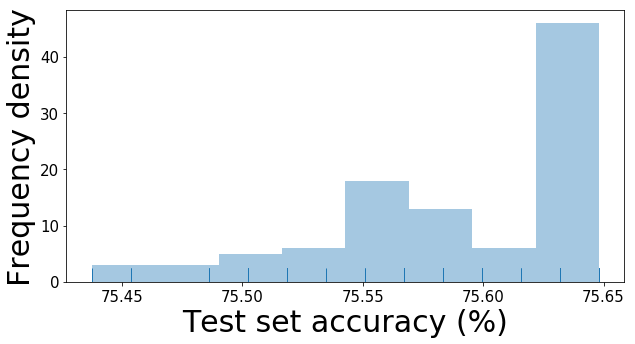

In [14]:
# Display test accuracy

# average accuracy across 100 samples for binary class problem (Low v. Medium/High)
# n_epochs = 100, batch_size = 25
# all variables: 75.503%
# all variables, less num. priors: 67.489%
# num. priors only: 68.237%

n_test_samples = 100
test_logits = bnn.sample_logits(x_test_mat, n_test_samples)
accuracy_hist(test_logits, y_test_mat)

## RATE

Now compute RATE. Start with the means and covariances of the final layer. Then get the network output at the penultimate layer, `H`, and use it to compute the means and covariances of the multivariate effect size analgoues.

In [15]:
M_W, V_W, b = bnn.var_params() # Means and covariances of the variational parameters (final layer weight matrix elements)
X = x_test_mat # Using the whole test set
H = bnn.compute_H(X) # (Deterministic) values of penultimate network layer
effect_size = 'covariance'  # use covariance analogue
M_B, V_B = compute_B(X, H, M_W, V_W, b, C, effect_size_analogue=effect_size) # Means and covariances of the effect size analogues
rate = [RATE(mu_c=M_B[c,:], Lambda_c=V_B[c,:,:]) for c in range(C)] # Per-class RATE values. First order centrality.

0


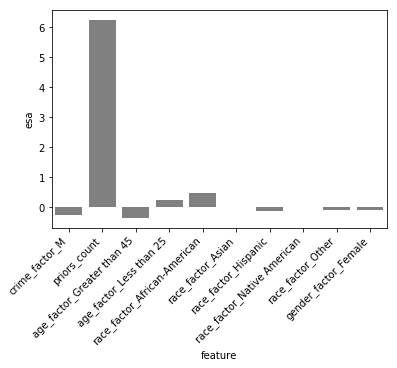

In [16]:
# Plot effect size means

if not multiclass:
    # binary case
    esa_dat=pd.DataFrame(data = {'esa': M_B.flatten(), 'variance': list(np.diagonal(V_B[0]).T)})
    esa_dat['feature'] = bnn_predictors

    fig_esa = sns.barplot(x="feature", y="esa", color = "gray", data=esa_dat)
    fig_esa.set_xticklabels(fig_esa.get_xticklabels(), rotation = 45, ha="right")
else: 
    # three responses
    fig, axs = plt.subplots(1, 3)
    for response in np.arange(C):
        esa_dat=pd.DataFrame(data = {'esa': M_B[response, :].flatten(), 'variance': list(np.diagonal(V_B[response, :, :]).T)})
        esa_dat['feature'] = bnn_predictors

        fig_esa = sns.barplot(x="feature", y="esa", color = "gray", data=esa_dat, ax=axs[response])
        fig_esa.set_xticklabels(fig_esa.get_xticklabels(), rotation = 45, ha="right")
        fig_esa.set(title = response_columns[response])
    
# save effect size analogue posterior means and variance posterior if num. priors not shuffled and response is binary

# if not multiclass: 
#     if not shuffle and not normalsmp and num_ProPublica_features == len(bnn_predictors):
#         # using all predictors
#         esa_dat.to_csv("COMPAS_BNN_ESA_Variance.csv", index=False) 

#     if not shuffle and not normalsmp and num_ProPublica_features > len(bnn_predictors):
#         # omitting priors_count
#         esa_dat.to_csv("COMPAS_BNN_ESA_Variance_numPriorsOmitted.csv", index=False)     

#     if shuffle and not normalsmp:
#         # shuffling priors count
#         esa_dat.to_csv("COMPAS_BNN_ESA_Variance_numPriorsShuffled.csv", index=False) 

#     if shuffle and normalsmp:
#         # priors count ~ n(0, 1)
#         esa_dat.to_csv("COMPAS_BNN_ESA_Variance_numPriorsNormalSmp.csv", index=False) 

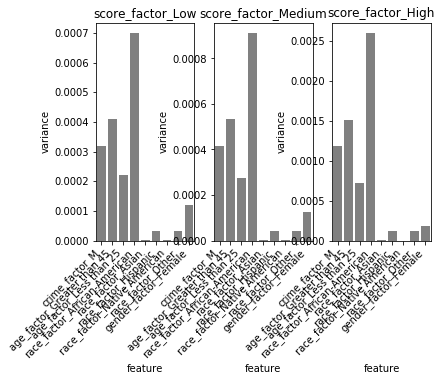

In [241]:
# Plot variance of effect size

if not multiclass:
    # binary case
    fig_var = sns.barplot(x="feature", y="variance", color = "gray", data=esa_dat)
    fig_var.set_xticklabels(fig_var.get_xticklabels(), rotation = 45, ha="right")
else: 
    # three responses
    fig, axs = plt.subplots(1, 3)
    for response in np.arange(C):
        esa_dat=pd.DataFrame(data = {'esa': M_B[response, :].flatten(), 'variance': list(np.diagonal(V_B[response, :, :]).T)})
        esa_dat['feature'] = bnn_predictors

        fig_esa = sns.barplot(x="feature", y="variance", color = "gray", data=esa_dat, ax=axs[response])
        fig_esa.set_xticklabels(fig_esa.get_xticklabels(), rotation = 45, ha="right")
        fig_esa.set(title = response_columns[response])

In [17]:
# Assemble RATE dataset with covariate names
# RATE vectors should agree with one another.
# Be mindful that from here on, when organizing RATE values into dataset to save, 
# if a variable was removed, it is hardcoded in some places that that variable is priors_count.
# Modify as desired.

rate_data = pd.DataFrame(np.transpose([rate[c] for c in range(C)]), 
                         # rate_class0 is the label in the binary case because there's only 1 response vector.
                         columns=list(['rate_class' + str(c) for c in range(C)]))

column_dict = {#'two_year_recid': 'Reoffended (Y/N)', 
          'crime_factor_M': 'Severity of Charge: M', 
          'priors_count': 'Num. Priors', 
          'priors_count_shuffled': 'Num. Priors Shuffled',
          'priors_count_normalsmp': 'Num. Priors Standard Normal Sample', 
          'age_factor_Greater than 45': '> 45 Yrs. Old', 
          'age_factor_Less than 25': '< 25 Yrs. Old', 
          'race_factor_African-American': 'Race: African-American', 
          'race_factor_Asian': 'Race: Asian', 
          'race_factor_Hispanic': 'Race: Hispanic', 
          'race_factor_Native American': 'Race: Native-American', 
          'race_factor_Other': 'Race: Other', 
          'gender_factor_Female': 'Female'}  
rate_data['var_names'] = bnn_predictors
rate_data['feature'] = [column_dict[col] for col in rate_data['var_names']]

# if using all features, 
# want to remember this ordering 
# first order centrality, all variables included
# when you run this script, be sure to run that first!
# this doesn't matter in binary case, but note that for multiclass, this ordering 
#    goes by importance for predicting score=Low.
if num_ProPublica_features == len(bnn_predictors):
    rate_data.sort_values(by=['rate_class0'], inplace=True, ascending=False)

    # save sort order
    all_features_order = rate_data['feature']
    sorterIndex = dict(zip(all_features_order, range(len(all_features_order))))

rate_data['first_order_ranking'] = rate_data['feature'].map(sorterIndex)
rate_data.sort_values(by = ['first_order_ranking'], inplace=True)
centrality_label = 'First'

# save this data for when we write to csv
if shuffle and not normalsmp: 
    # priors count is shuffled
    rate_data_temp = rate_data.copy()
    rate_data_temp['var_names'].replace("priors_count_shuffled", "priors_count", inplace=True)
    identifying_tag = "_numPriorsShuffled"
elif shuffle and normalsmp: 
    # priors count is a N(0, 1) sample
    rate_data_temp = rate_data.copy()
    rate_data_temp['var_names'].replace("priors_count_normalsmp", "priors_count", inplace=True)
    identifying_tag = "_numPriorsNormalSmp"
elif num_ProPublica_features > len(bnn_predictors):
    # we are omitting priors_count from the analysis
    print "num. priors omitted from analysis"
    rate_data_temp = rate_data.copy()
    line_to_append = dict.fromkeys(rate_data_temp.columns)
    line_to_append['var_names'] = 'priors_count'
    line_to_append['feature'] = column_dict['priors_count']
    line_to_append['rate_class0'] = 0
    line_to_append['rate_class1'] = 0
    line_to_append['rate_class2'] = 0
    rate_data_temp = rate_data_temp.append(line_to_append, ignore_index=True)
    identifying_tag = "_numPriorsOmitted"
elif num_ProPublica_features == len(bnn_predictors):
    # including all predictors
    identifying_tag = ""

# modify rate_data_csv!
if not multiclass: 
    # binary case
    
    if shuffle or num_ProPublica_features > len(bnn_predictors): 
        # if we're shuffled num. priors or omitting it
        rate_data_csv = rate_data_csv.merge(rate_data_temp.ix[:, ["var_names", "rate_class0"]], on=["var_names"])
    elif num_ProPublica_features == len(bnn_predictors):
        # all variables are included in the analysis
        rate_data_csv = rate_data_csv.merge(rate_data.ix[:, ["var_names", "rate_class0"]], on=["var_names"])
        
    rate_data_csv.rename(index=str, columns={"rate_class0": "rate_class0_1stOrder" + identifying_tag}, 
                        inplace=True)
else: 
    # three responses
    
    if shuffle or num_ProPublica_features > len(bnn_predictors): 
        # if we're shuffled num. priors or omitting it
        rate_data_csv = rate_data_csv.merge(rate_data_temp.ix[:, ["var_names", "rate_class0", "rate_class1", "rate_class2"]], 
                                            on=["var_names"])
    elif num_ProPublica_features == len(bnn_predictors):
        # all variables are included in the analysis 
        rate_data_csv = rate_data_csv.merge(rate_data.ix[:, ["var_names", "rate_class0", "rate_class1", "rate_class2"]], 
                                            on=["var_names"])
    
    rate_data_csv.rename(index=str, columns={"rate_class0": "rate_class0_1stOrder" + identifying_tag, 
                                        "rate_class1": "rate_class1_1stOrder" + identifying_tag, 
                                        "rate_class2": "rate_class2_1stOrder" + identifying_tag}, inplace=True)

/home/jonathan/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:80: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/jonathan/miniconda2/lib/python2.7/site-packages/pandas/core/indexing.py:890: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


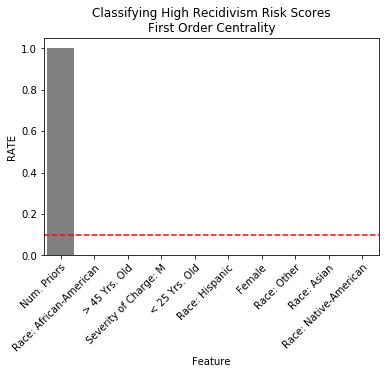

In [18]:
# Plot RATE values

if not multiclass: 
    # binary case
    fig = sns.barplot(x="feature", y="rate_class0", color = "gray", data=rate_data)
    fig.set_xticklabels(fig.get_xticklabels(), rotation = 45, ha="right")
    for item in fig.get_xticklabels():
        item.set_rotation_mode('anchor')
    if shuffle:  # if we shuffled num. priors
        title_text = 'Classifying High Recidivism Risk Scores\n' + centrality_label + ' Order Centrality\nNum. Priors Shuffled'
    else: 
        title_text = 'Classifying High Recidivism Risk Scores\n' + centrality_label + ' Order Centrality'
    fig.set(xlabel='Feature', ylabel='RATE', title=title_text)
    fig.axhline(y = 1.0 / len(x_train.columns), ls='--', color = "red")  # add line at 1/p (all variables equally important)
else: 
    # three responses
    if shuffle:  # if we shuffled num. priors
        print 'Classifying High Recidivism Risk Scores\n' + centrality_label + ' Order Centrality\nNum. Priors Shuffled'
    else: 
        print 'Classifying High Recidivism Risk Scores\n' + centrality_label + ' Order Centrality'
            
    fig, axs = plt.subplots(1, 3)
    for response in np.arange(C):
        fig = sns.barplot(x="feature", y="rate_class" + str(response), color = "gray", data=rate_data, ax=axs[response])
        fig.set_xticklabels(fig.get_xticklabels(), rotation = 45, ha="right")
        for item in fig.get_xticklabels():
            item.set_rotation_mode('anchor')
        fig.set(xlabel='Feature', ylabel='RATE', title=response_columns[response])
        fig.axhline(y = 1.0 / len(x_train.columns), ls='--', color = "red")  # add line at 1/p (all variables equally important)

In [19]:
# Second order centrality (condition on num. priors effect size = 0)

if effect_size == 'linear': 
    var_to_nullify = np.array(rate_data.ix[rate_data['first_order_ranking'] == 0, 'var_names'])[0]
    nullified_var_label = "_pseudoInv"
elif not shuffle and num_ProPublica_features == len(bnn_predictors): 
    # all variables are included in the analysis
    var_to_nullify = 'priors_count'
    nullified_var_label = ''
elif not shuffle and num_ProPublica_features > len(bnn_predictors): 
    # priors count is omitted from the analysis
    var_to_nullify = 'race_factor_African-American'
    nullified_var_label = '_numPriorsOmitted'    
elif shuffle and not normalsmp:
    # priors count is permuted
    var_to_nullify = 'priors_count_shuffled'
    nullified_var_label = '_numPriorsShuffled'
elif shuffle and normalsmp:
    # priors count is a N(0, 1) sample
    var_to_nullify = 'priors_count_normalsmp'
    nullified_var_label = '_numPriorsNormalSmp'

priors_count_idx = list(bnn_predictors).index(var_to_nullify)
rate = [RATE(mu_c=M_B[c,:], Lambda_c=V_B[c,:,:], nullify=[priors_count_idx]) for c in range(C)] # Per-class RATE values. 2nd order

rate_data = pd.DataFrame(np.transpose([rate[c] for c in range(C)]), 
                         columns=list(['rate_class' + str(c) for c in range(C)]))

var_names = list(bnn_predictors)
var_names.remove(var_to_nullify)
rate_data['var_names'] = var_names
if not multiclass: 
    # binary case
    rate_data.append({'rate_class0': 0, 'var_names': var_to_nullify}, ignore_index=True)
else: 
    # three responses
    rate_data.append({'rate_class0': 0, 'rate_class1': 0, 'rate_class2': 0, 'var_names': var_to_nullify}, ignore_index=True)
rate_data['feature'] = [column_dict[col] for col in rate_data['var_names']]

# include nullified variable on plot, for visual continuity, though it has no RATE value
missing_features = set(bnn_predictors) - set(var_names)
centrality_label = {2:'Second', 3:'Third', 4:'Fourth', 5:'Fifth', 6:'Sixth', 7:'Seventh', 8:'Eighth'}[len(missing_features)+1]
for var in missing_features:
    if not multiclass: 
        # binary case
        rate_data = rate_data.append({'var_names': var, 
                                     'rate_class0': 0}, ignore_index=True)
    else: 
        # three responses
        rate_data = rate_data.append({'var_names': var, 
                                     'rate_class0': 0, 
                                     'rate_class1': 0, 
                                     'rate_class2': 0}, ignore_index=True)
        
# order by first order centrality   
# you have to have previously run first order centrality!
rate_data['first_order_ranking'] = rate_data['feature'].map(sorterIndex)
rate_data.sort_values(by = ['first_order_ranking'], inplace=True)

# save this data for when we write to csv
rate_data_temp = rate_data.copy()
if var_to_nullify == 'race_factor_African-American':
    # if priors count is omitted fully from the analysis
    line_to_append = dict.fromkeys(rate_data_temp.columns)
    line_to_append['var_names'] = 'priors_count'
    line_to_append['feature'] = column_dict['priors_count']
    line_to_append['rate_class0'] = 0
    if multiclass: 
        line_to_append['rate_class1'] = 0
        line_to_append['rate_class2'] = 0
    rate_data_temp = rate_data_temp.append(line_to_append, ignore_index=True)

if not multiclass: 
    # binary case
    rate_data_csv = rate_data_csv.merge(rate_data_temp.ix[:, ['var_names', 'rate_class0']], on = ['var_names'])
    rate_data_csv.rename(index=str, columns={"rate_class0": "rate_class0_2ndOrder" + nullified_var_label}, 
                        inplace=True)
else: 
    # three responses
    rate_data_csv = rate_data_csv.merge(rate_data_temp.ix[:, ['var_names', 'rate_class0', 'rate_class1', 'rate_class2']], 
                                        on = ['var_names'])
    rate_data_csv.rename(index=str, columns={"rate_class0": "rate_class0_2ndOrder" + nullified_var_label, 
                                            "rate_class1": "rate_class1_2ndOrder" + nullified_var_label, 
                                            "rate_class2": "rate_class2_2ndOrder" + nullified_var_label}, 
                        inplace=True)

0


/home/jonathan/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/jonathan/miniconda2/lib/python2.7/site-packages/pandas/core/indexing.py:890: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


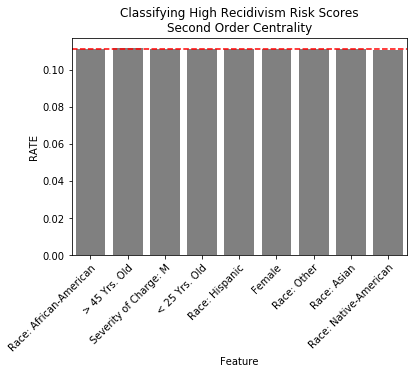

In [20]:
# Plot 2nd Order RATE values

if not multiclass: 
    # binary case
    fig = sns.barplot(x="feature", y="rate_class0", color = "gray", data=rate_data)
    fig.set_xticklabels(fig.get_xticklabels(), rotation = 45, ha="right")
    for item in fig.get_xticklabels():
    #     item.set_rotation(45)
        item.set_rotation_mode('anchor')
    fig.set(xlabel='Feature', ylabel='RATE', title='Classifying High Recidivism Risk Scores\n' + 
           centrality_label + ' Order Centrality')
    fig.axhline(y = 1.0 / (len(bnn_predictors) - 1), ls='--', color = "red")  # add line at 1/p (all variables equally important)
else: 
    # three responses
    print 'Classifying High Recidivism Risk Scores\n' + centrality_label + ' Order Centrality'
    fig, axs = plt.subplots(1, 3)
    for response in np.arange(C):
        fig = sns.barplot(x="feature", y="rate_class" + str(response), color = "gray", data=rate_data, ax=axs[response])
        fig.set_xticklabels(fig.get_xticklabels(), rotation = 45, ha="right")
        for item in fig.get_xticklabels():
            item.set_rotation_mode('anchor')
        fig.set(xlabel='Feature', ylabel='RATE', title=response_columns[response])
        fig.axhline(y = 1.0 / len(x_train.columns), ls='--', color = "red")  # add line at 1/p (all variables equally important)

In [21]:
# grab feature names for rate data to save

column_dict = {#'two_year_recid': 'Reoffended (Y/N)', 
                  'crime_factor_M': 'Severity of Charge: M', 
                  'priors_count': 'Num. Priors', 
                  'age_factor_Greater than 45': '> 45 Yrs. Old', 
                  'age_factor_Less than 25': '< 25 Yrs. Old', 
                  'race_factor_African-American': 'Race: African-American', 
                  'race_factor_Asian': 'Race: Asian', 
                  'race_factor_Hispanic': 'Race: Hispanic', 
                  'race_factor_Native American': 'Race: Native-American', 
                  'race_factor_Other': 'Race: Other', 
                  'gender_factor_Female': 'Female'}

rate_data_csv['feature'] = [column_dict[col] for col in rate_data_csv['var_names']]

In [249]:
# Export RATE values

# if not multiclass: 
#     # binary case
#     rate_data_csv.to_csv("COMPAS_BNN_RATE.csv", index=False)
# else:
#     # three responses
#     rate_data_csv.to_csv("COMPAS_BNN_RATE_multinomialResponse.csv", index=False)